In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy.stats import t, norm, gamma, halfnorm

# Data 
np.random.seed(42)
n = 100
mu_true = 0
sigma2_true = 1
nu_true = 5
x = t.rvs(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true), size=n)

# Hyperparameters for priors
mu0, tau0 = 0, 1    # Normal prior for mu
sigma0 = 1          # Half normal prior for sigma^2
nu_values = np.arange(1, 101)  # Discrete uniform prior for nu

# Metropolis-Hastings settings
G = 10000  # of iterations
burn_in = 2000  # Burn-in
prop_sd_mu = 0.5  # Proposal std for mu
prop_sd_log_sigma2 = 0.5  # Proposal std for log(sigma^2)
prop_sd_nu = 1  # Proposal step for discrete nu

# Initialize chains
mu = np.zeros(G)
sigma2 = np.ones(G)
nu = np.full(G, 10)

# Log posterior function
def log_posterior(mu, sigma2, nu, x):
    log_likelihood = np.sum(t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
    log_prior_mu = norm.logpdf(mu, mu0, np.sqrt(1/tau0))
    log_prior_sigma2 = halfnorm.logpdf(np.sqrt(sigma2), scale=sigma0)  # Half-normal prior
    log_prior_nu = -np.log(100) if 1 <= nu <= 100 else -np.inf  # Discrete uniform
    return log_likelihood + log_prior_mu + log_prior_sigma2 + log_prior_nu

# Metropolis-within-Gibbs Sampler
for g in range(1, G):
    # Update mu
    mu_prop = np.random.normal(mu[g-1], prop_sd_mu)
    log_alpha_mu = log_posterior(mu_prop, sigma2[g-1], nu[g-1], x) - log_posterior(mu[g-1], sigma2[g-1], nu[g-1], x)
    if np.log(np.random.rand()) < min(0, log_alpha_mu):
        mu[g] = mu_prop
    else:
        mu[g] = mu[g-1]
    
    # Update sigma^2 (using log-normal proposal)
    log_sigma2_prop = np.random.normal(np.log(sigma2[g-1]), prop_sd_log_sigma2)
    sigma2_prop = np.exp(log_sigma2_prop)
    log_alpha_sigma2 = log_posterior(mu[g], sigma2_prop, nu[g-1], x) - log_posterior(mu[g], sigma2[g-1], nu[g-1], x)
    if np.log(np.random.rand()) < min(0, log_alpha_sigma2):
        sigma2[g] = sigma2_prop
    else:
        sigma2[g] = sigma2[g-1]
    
    # Update nu (discrete Metropolis step)
    nu_prop = np.clip(nu[g-1] + np.random.choice([-1, 1]), 1, 100)  # Jump to a neighbor
    log_alpha_nu = log_posterior(mu[g], sigma2[g], nu_prop, x) - log_posterior(mu[g], sigma2[g], nu[g-1], x)
    if np.log(np.random.rand()) < min(0, log_alpha_nu):
        nu[g] = nu_prop
    else:
        nu[g] = nu[g-1]

# Post burn-in samples
mu_samples = mu[burn_in:]
sigma2_samples = sigma2[burn_in:]
nu_samples = nu[burn_in:]




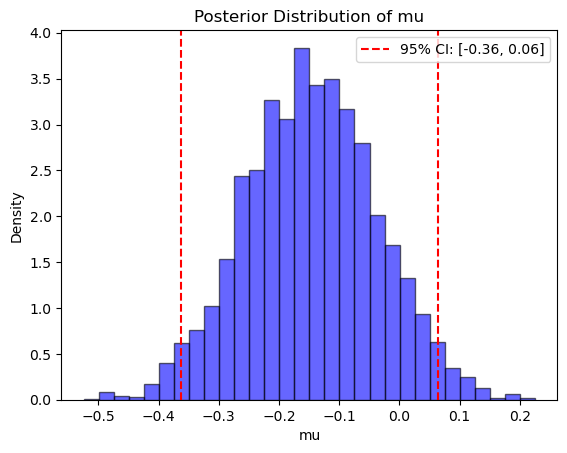

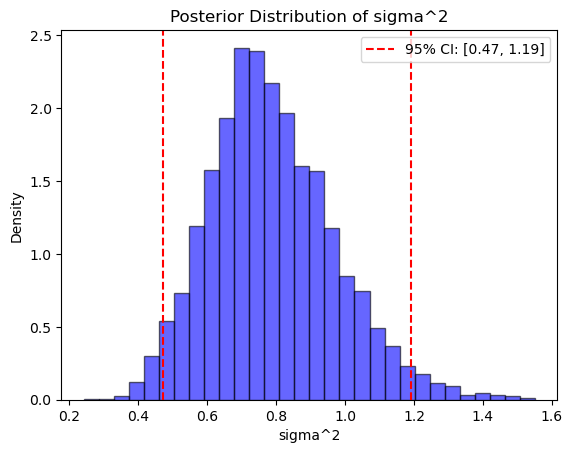

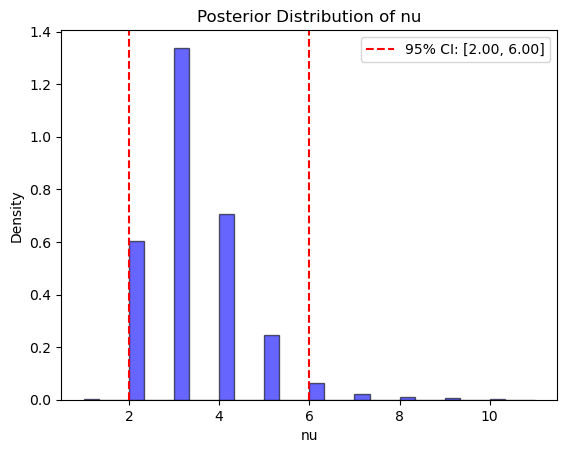

In [2]:
def plot_histogram(samples, param_name):
    plt.hist(samples, bins=30, density=True,edgecolor = 'black', alpha=0.6, color='b')
    ci_low, ci_high = np.percentile(samples, [2.5, 97.5])
    plt.axvline(ci_low, color='r', linestyle='dashed', label=f'95% CI: [{ci_low:.2f}, {ci_high:.2f}]')
    plt.axvline(ci_high, color='r', linestyle='dashed')
    plt.title(f"Posterior Distribution of {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot_histogram(mu_samples, "mu")
plot_histogram(sigma2_samples, "sigma^2")
plot_histogram(nu_samples, "nu")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     -0.145  0.109  -0.348    0.060      0.001    0.001    7789.0    5573.0   
nu      3.453  1.137   2.000    5.000      0.042    0.030     812.0    1214.0   
sigma2  0.821  0.187   0.485    1.176      0.004    0.003    1731.0    3616.0   

        r_hat  
mu       1.00  
nu       1.01  
sigma2   1.01  


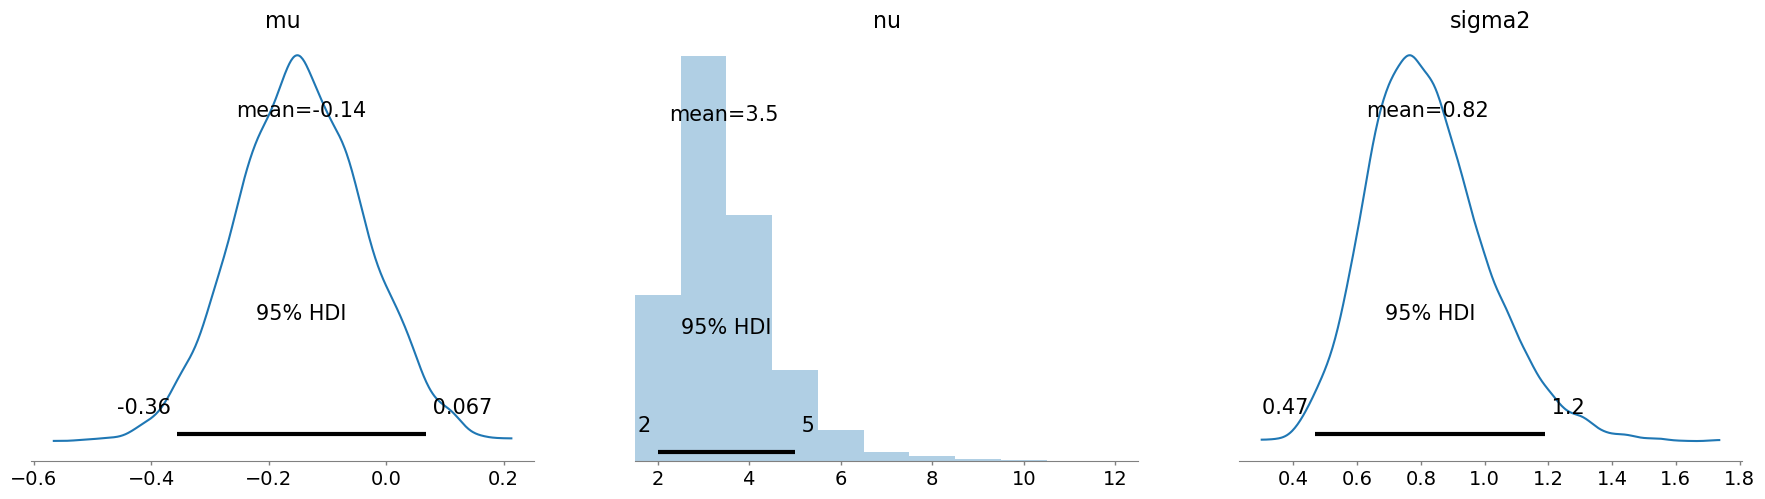

In [3]:
#Q2

#Data 
np.random.seed(42)
n = 100
mu_true = 0
sigma2_true = 1
nu_true = 5
x = t.rvs(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true), size=n)


with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)
    
    likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, sigma=pm.math.sqrt(sigma2), observed=x)
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=4)

# Summary 
print(az.summary(trace))


# Plot posterior distributions
az.plot_posterior(trace, hdi_prob=0.95)
plt.show()


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Summary for sample size 50
          mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu       0.314   0.149   0.045    0.602      0.004    0.003    1574.0   
nu      22.253  26.584   1.000   80.000      1.881    1.332     132.0   
sigma2   0.920   0.375   0.267    1.540      0.029    0.020     169.0   

        ess_tail  r_hat  
mu        1928.0   1.00  
nu         142.0   1.03  
sigma2     589.0   1.02  


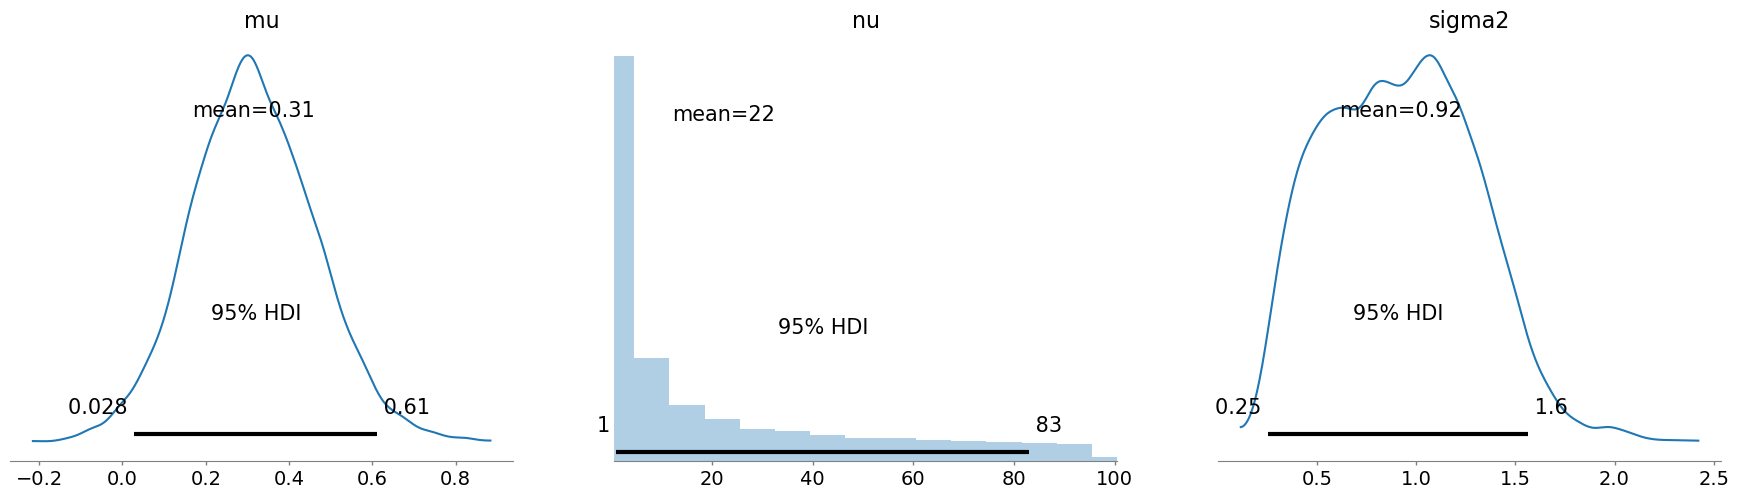

Summary for sample size 100
          mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu      -0.147   0.114  -0.355    0.072      0.001    0.001    8222.0   
nu      51.925  27.587   7.000   96.000      0.732    0.518    1322.0   
sigma2   1.244   0.194   0.878    1.596      0.003    0.002    3912.0   

        ess_tail  r_hat  
mu        6097.0    1.0  
nu        1155.0    1.0  
sigma2    3393.0    1.0  


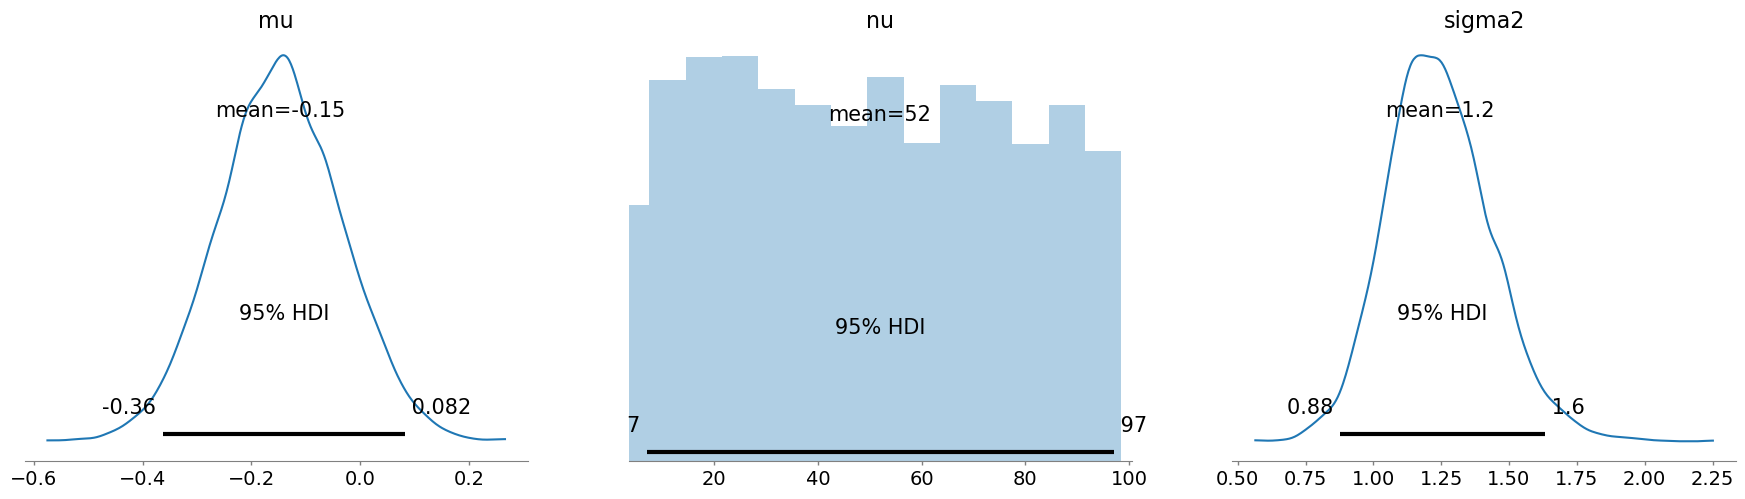

Summary for sample size 500
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     -0.022  0.052  -0.120    0.078      0.001    0.001    6581.0    4902.0   
nu      5.834  1.613   3.000    8.000      0.072    0.051     489.0     491.0   
sigma2  0.991  0.109   0.788    1.195      0.004    0.003     806.0    1827.0   

        r_hat  
mu       1.00  
nu       1.01  
sigma2   1.00  


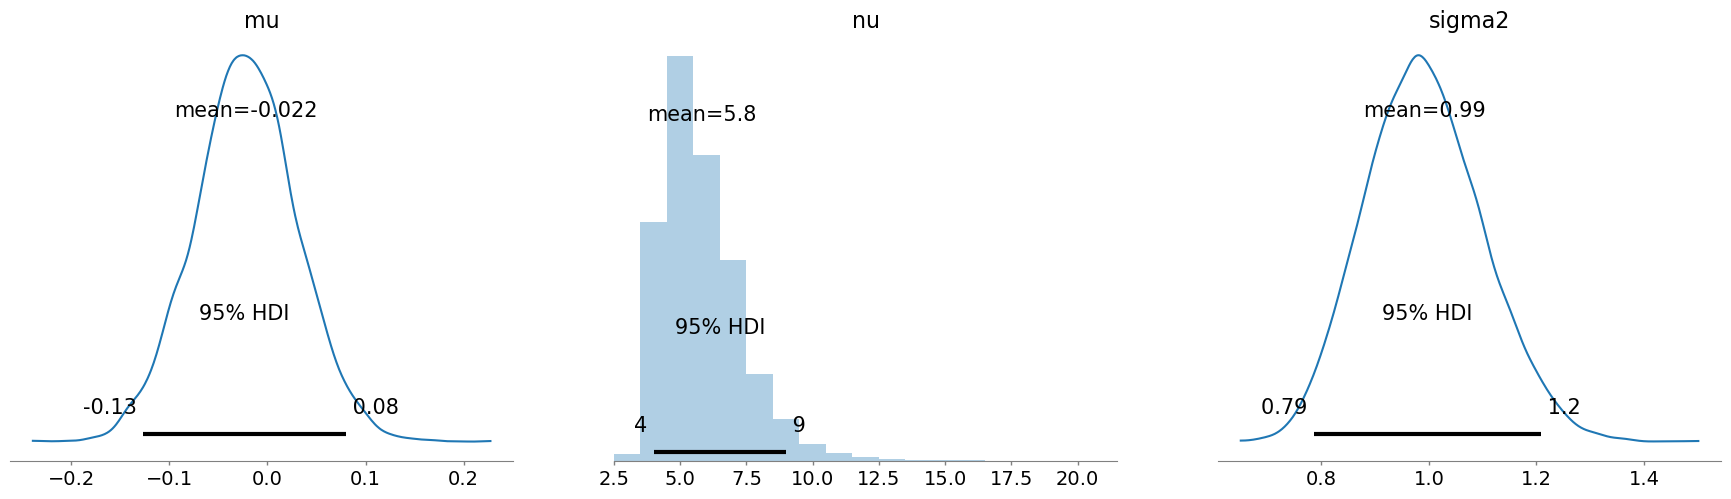

In [4]:
# Experiment with different sample sizes
sample_sizes = [50, 100, 500]
traces = {}
for n in sample_sizes:
    x_sample = t.rvs(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true), size=n)
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=1)
        sigma2 = pm.HalfNormal("sigma2", sigma=1)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, sigma=pm.math.sqrt(sigma2), observed=x_sample)
        traces[n] = pm.sample(2000, tune=1000, return_inferencedata=True, cores=4)

# Compare results
for n, trace_n in traces.items():
    print(f"Summary for sample size {n}")
    print(az.summary(trace_n))
    az.plot_posterior(trace_n, hdi_prob=0.95)
    plt.show()

As the sample size increases, the posterior estimates for $\mu$, $\sigma^2$, and $\nu$ become more concentrated around their true values, which is the expected behavior of Bayesian inference. With smaller sample sizes ($n=50$), the credible intervals are wider, indicating greater uncertainty in parameter estimates. In particular, the estimation of $\nu$, which controls the heaviness of the tails in the Student-t distribution, is highly sensitive to sample size, small datasets struggle to pin down the shape of the distribution, often leading to over- or under-estimation of degrees of freedom. As $n$ grows to 100 and 500, the posterior distributions narrow significantly, showing improved precision. The reduction in uncertainty is especially pronounced for $\sigma^2$, where larger datasets provide a clearer estimate about the scale of the data. These findings show the importance of sufficient sample size in Bayesian analysis, particularly when estimating parameters governing tail behavior, such as $\nu$.


# **Q3: Derivation of the Posterior Predictive Distribution**


1. A **Gamma prior** on the precision (inverse variance) $\tau_i$:

   $$
   p(\tau_i) = \text{Gamma}(\tau_i \mid \alpha = \nu/2, \beta = \nu/2)
   $$

   which has the explicit density function:

   $$
   p(\tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2} - 1} e^{-\frac{\nu}{2} \tau_i}.
   $$

2. A **Normal likelihood function** for $ y_i $ given $ \tau_i $:

   $$
   p(y_i \mid \tau_i) = \mathcal{N}(y_i \mid 0, \tau_i^{-1})
   $$

   which has the explicit density function:

   $$
   p(y_i \mid \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2}.
   $$

3. We seek to compute the **marginal (posterior predictive) distribution**:

   $$
   p(y_i) = \int_0^\infty p(y_i \mid \tau_i) p(\tau_i) d\tau_i.
   $$

---

Substituting the given distributions into the integral:

$$
p(y_i) = \int_0^\infty \left( \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \right) \left( \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2} - 1} e^{-\frac{\nu}{2} \tau_i} \right) d\tau_i.
$$

Rearranging terms:

$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\left(\frac{\nu}{2}\right)} \cdot \sqrt{\frac{1}{2\pi}} \int_0^\infty \tau_i^{\frac{\nu}{2} - 1 + \frac{1}{2}} e^{-\frac{1}{2} (\nu + y_i^2) \tau_i} d\tau_i.
$$

This simplifies to:

$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\left(\frac{\nu}{2}\right)} \cdot \sqrt{\frac{1}{2\pi}} \int_0^\infty \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\frac{1}{2} (\nu + y_i^2) \tau_i} d\tau_i.
$$

---

The integral here is a standard **Gamma function integral** of the form:

$$
\int_0^\infty x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}, \quad \text{for } a, b > 0.
$$

Comparing, we set:

- $ a = \frac{\nu}{2} + \frac{1}{2} $,
- $ b = \frac{1}{2} (\nu + y_i^2) $.

Applying the Gamma function result:

$$
\int_0^\infty \tau_i^{\frac{\nu}{2} - \frac{1}{2}} e^{-\frac{1}{2} (\nu + y_i^2) \tau_i} d\tau_i = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left( \frac{1}{2} (\nu + y_i^2) \right)^{\frac{\nu+1}{2}}}.
$$

---

Substituting back:

$$
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\left(\frac{\nu}{2}\right)} \cdot \sqrt{\frac{1}{2\pi}} \cdot \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left( \frac{1}{2} (\nu + y_i^2) \right)^{\frac{\nu+1}{2}}}.
$$

Rewriting:

$$
p(y_i) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \cdot \frac{1}{\sqrt{\nu \pi}} \cdot \left(1 + \frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}.
$$

This is the Student’s t-distribution:

$$
p(y_i) \sim t_\nu(0, 1),
$$

where $\nu$ is the degrees of freedom.

---

The result demonstrates that incorporating uncertainty in the variance leads to a Student’s t-distribution for the posterior predictive distribution, rather than a normal distribution. This occurs because the normal likelihood assumes a fixed variance, whereas the Bayesian approach integrates over possible variance values using the Gamma prior. The t-distribution’s heavier tails make it more robust to outliers and better suited for real-world scenarios where variance is uncertain.
